<a href="https://colab.research.google.com/github/VivekGupta137/Dress-recognition/blob/master/Dress_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp '/content/drive/Shared drives/Pahe/download/yolov3.weights' .
!cp '/content/drive/Shared drives/Pahe/download/dress-recognition.zip' .
!cp '/content/drive/Shared drives/Pahe/download/cfmodel96.34.h5' .
!cp '/content/drive/Shared drives/Pahe/download/yolov3model.h5' .
!unzip 'dress-recognition.zip'

In [ ]:
!cp '/content/drive/Shared drives/Pahe/download/dress-recognition.zip' '/content/drive/My Drive/Colab Notebooks/DressRecognitionDataset'

In [ ]:
# !unzip 'dress-recognition.zip' -d '/content/drive/My Drive/testing_data/'
# !tar -czvf '/content/drive/My Drive/testing_data/test.tar.gz' '/content/drive/My Drive/testing_data/Dress Recognition/Test-Dataset'
from google.colab import drive

In [ ]:
drive.flush_and_unmount()

In [ ]:
# create a YOLOv3 Keras model and save it to file
# based on https://github.com/experiencor/keras-yolo3
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model

def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x

def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0


import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [ ]:
!wget https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/zebra.jpg

--2020-05-23 02:03:52--  https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/zebra.jpg
Resolving 3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com (3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com)... 108.161.188.228
Connecting to 3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com (3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com)|108.161.188.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240195 (235K) [image/jpeg]
Saving to: ‘zebra.jpg’

zebra.jpg           100%[===================>] 234.57K  --.-KB/s    in 0.01s   

2020-05-23 02:03:52 (18.9 MB/s) - ‘zebra.jpg’ saved [240195/240195]



In [ ]:
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    # image = load_img(filename)
    # width, height = image.size
    image = cv2.imread(filename)
    width = image.shape[1]
    height = image.shape[0]
    # load the image with the required size
    image = cv2.resize(image,shape)
    # image = load_img(filename, target_size=shape)
    # convert to numpy array
    # image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416

# define our new photo
photo_filename = 'Dress_Recognition/Test-Dataset/T-Shirt.67.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [ ]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

In [ ]:
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [ ]:
# suppress non-maximal boxes
do_nms(boxes, 0.5)

In [ ]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

In [ ]:
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

In [ ]:
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

person 99.93635416030884


In [ ]:
# box[0] coordinates
y1, x1, y2, x2 = v_boxes[0].ymin, v_boxes[0].xmin, v_boxes[0].ymax, v_boxes[0].xmax
print(y1, x1, y2, x2)

107 157 264 392


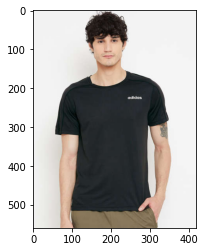

In [ ]:
tst_img = cv2.imread('Dress_Recognition/Test-Dataset/T-Shirt.67.jpg')
plt.imshow((tst_img[y1:y2,x1:x2,])[:,:,::-1])
# load_image_pixels('zebra.jpg',(416,416))[1:]
# tst_img.shape

In [ ]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='blue')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='red')
	# show the plot
	pyplot.show()

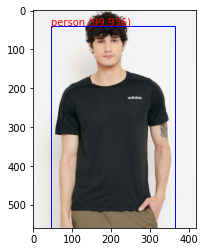

In [ ]:

draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [ ]:
import numpy as np
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from keras import applications
import tensorflow as tf
import os
from subprocess import call
import cv2

In [ ]:
categories = np.array(['Formal_Shirt', 'Kurti', 'Saree', 'T-Shirt', 'Unknown'])
n_categories = 5

In [ ]:
color = (255,255,255)
padded_image = np.full((416,416,3), color, dtype=np.uint8)
y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
padded_image[y1:y2,x1:x2] = cropped_img[y1:y2,x1:x2]*255
img_in_frame,v_boxes, v_labels, v_scores = detect_person('Dress_Recognition/Test-Dataset/T-Shirt.81.jpg')
for i in range(len(img_in_frame)):
print(make_prediction(img_in_frame[i], v_boxes[i]))

In [ ]:
x_train_all = []
y_train_all = []

shape = (416,416)
for dirname, _, filenames in os.walk('Dress_Recognition/Dataset'):
  for filename in filenames:
    # image = cv2.imread(os.path.join(dirname, filename))
    # img = cv2.resize(image,shape)
    img_in_frame,v_boxes, v_labels, v_scores = detect_person(os.path.join(dirname, filename))
    for i in range(len(img_in_frame)):
      color = (255,255,255)
      img = np.full((416,416,3), color, dtype=np.uint8)
      y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
      img[y1:y2,x1:x2] = cropped_img[y1:y2,x1:x2]*255

      x_train_all.append(img)
      y_train_all.append(np.where(categories==(filename.split('.')[:-2]))[0][0])
    # print(os.path.join(dirname, filename))
    # print(filename.split('.')[:-2])

x_test = []
y_test = []
for dirname, _, filenames in os.walk('Dress_Recognition/Test-Dataset'):
  for filename in filenames:
    # image, width, height = load_image_pixels(os.path.join(dirname, filename), shape)
    # image = cv2.imread(os.path.join(dirname, filename))
    # img = cv2.resize(image,shape)
    img_in_frame,v_boxes, v_labels, v_scores = detect_person(os.path.join(dirname, filename))
    for i in range(len(img_in_frame)):
      color = (255,255,255)
      img = np.full((416,416,3), color, dtype=np.uint8)
      y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
      img[y1:y2,x1:x2] = cropped_img[y1:y2,x1:x2]*255
      
      x_test.append(img)
      y_test.append(np.where(categories==(filename.split('.')[:-2]))[0][0])

# Dress_Recognition/Test-Dataset/T-Shirt.67.jpg

x_train_all = np.array(x_train_all)
x_test = np.array(x_test)

y_train_all = np.array(y_train_all)
y_test = np.array(y_test)

In [ ]:
# y_train_all.shape
len(x_test)
# plt.imshow(x_train_all[0])
print("x_train_all:", x_train_all.shape)
print("y_train_all:", y_train_all.shape)

print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train_all: (7000, 416, 416, 3)
y_train_all: (7000,)
x_test: (500, 416, 416, 3)
y_test: (500,)


In [ ]:
target = to_categorical(y_train_all)
target.shape

test_target = to_categorical(y_test)
test_target.shape

input_shape = x_train_all.shape[1:]

checkpoint = ModelCheckpoint('/content/drive/Shared drives/Pahe/download/weights.hdf5',monitor='val_loss',save_best_only=True)
early_monitor = EarlyStopping(patience = 10)


In [ ]:
cfmodel = Sequential()

cfmodel.add(Conv2D(10,kernel_size=3,activation='relu',input_shape=input_shape, padding='same'))
# cfmodel.add(MaxPool2D(2))
cfmodel.add(BatchNormalization())

cfmodel.add(Conv2D(20,kernel_size=3,activation='relu'))
cfmodel.add(MaxPool2D(2))
cfmodel.add(BatchNormalization())

cfmodel.add(Conv2D(30,kernel_size=3,activation='relu'))
cfmodel.add(MaxPool2D(2))
cfmodel.add(BatchNormalization())

cfmodel.add(Flatten())

cfmodel.add(Dense(30,activation='relu'))
cfmodel.add(Dropout(0.25))
cfmodel.add(BatchNormalization())

cfmodel.add(Dense(50,activation='relu'))
cfmodel.add(Dropout(0.25))
cfmodel.add(BatchNormalization())

cfmodel.add(Dense(80,activation='relu'))
cfmodel.add(Dropout(0.25))
cfmodel.add(BatchNormalization())

cfmodel.add(Dense(100,activation='relu'))
cfmodel.add(Dropout(0.25))
cfmodel.add(BatchNormalization())

cfmodel.add(Dense(5,activation='softmax'))

In [ ]:
cfmodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 416, 416, 10)      280       
_________________________________________________________________
batch_normalization_10 (Batc (None, 416, 416, 10)      40        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 414, 414, 20)      1820      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 207, 207, 20)      0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 207, 207, 20)      80        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 205, 205, 30)      5430      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 102, 102, 30)     

In [ ]:
cfmodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
training = cfmodel.fit(x_train_all,target, validation_split=0.3, epochs=50, callbacks=[checkpoint, early_monitor])

Train on 4900 samples, validate on 2100 samples
Epoch 1/50
4900/4900 [==============================] - 58s 12ms/step - loss: 1.4142 - accuracy: 0.4488 - val_loss: 1.5247 - val_accuracy: 0.3843
Epoch 2/50
4900/4900 [==============================] - 57s 12ms/step - loss: 0.9058 - accuracy: 0.6535 - val_loss: 1.0828 - val_accuracy: 0.5314
Epoch 3/50
4900/4900 [==============================] - 57s 12ms/step - loss: 0.6695 - accuracy: 0.7494 - val_loss: 0.4891 - val_accuracy: 0.8500
Epoch 4/50
4900/4900 [==============================] - 57s 12ms/step - loss: 0.5705 - accuracy: 0.7980 - val_loss: 0.4995 - val_accuracy: 0.8357
Epoch 5/50
4900/4900 [==============================] - 57s 12ms/step - loss: 0.4213 - accuracy: 0.8588 - val_loss: 0.3174 - val_accuracy: 0.9010
Epoch 6/50
4900/4900 [==============================] - 57s 12ms/step - loss: 0.5290 - accuracy: 0.8194 - val_loss: 0.4130 - val_accuracy: 0.8695
Epoch 7/50
4900/4900 [==============================] - 57s 12ms/step - loss

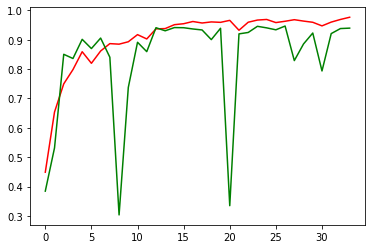

In [ ]:
plt.plot(training.history['accuracy'],'r')
plt.plot(training.history['val_accuracy'],'g')
plt.show()

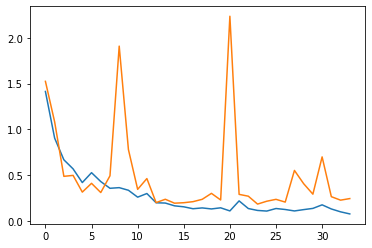

In [ ]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.show()

In [ ]:
cfmodel.load_weights('/content/drive/Shared drives/Pahe/download/weights.hdf5')

In [ ]:
cfmodel.evaluate(x_test,test_target)[1]*100

500/500 [==============================] - 2s 3ms/step


96.39999866485596

In [ ]:
cfmodel.save('/content/drive/Shared drives/Pahe/download/cfmodel96.34.h5')

--- 0.1208493709564209 seconds ---


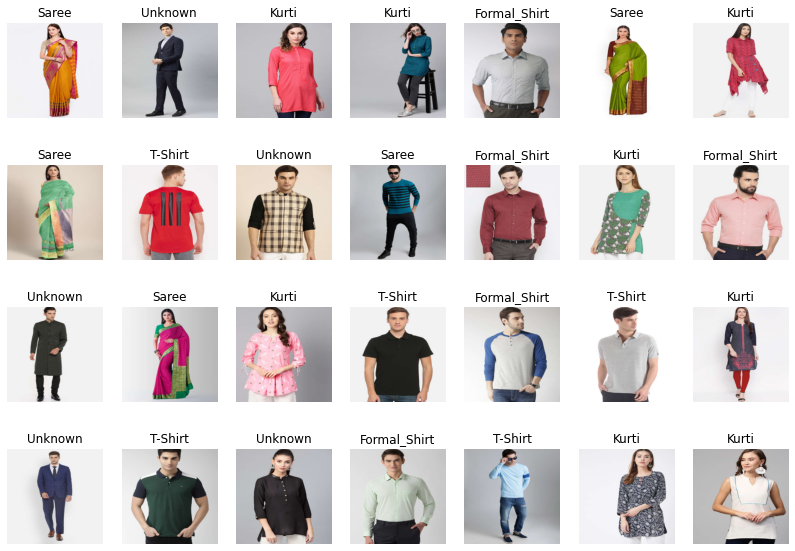

In [ ]:
import time
start_time = time.time()
fig = plt.figure(figsize=(14,10))
predictions = cfmodel.predict_classes(x_test[0:29])
print("--- %s seconds ---" % (time.time() - start_time))
for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    img = x_test[n]
    plt.imshow(img[:,:,::-1])
    plt.title(categories[predictions[n]])
    plt.axis('off')

--- model.predict = 0.0696556568145752 seconds ---
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
--- decode_netout = 0.018122434616088867 seconds ---
--- correct_yolo_boxes = 0.0022237300872802734 seconds ---
--- do_nms and get_boxes = 0.0032868385314941406 seconds ---
Person 99.93635416030884
--- 0.0034728050231933594 seconds ---


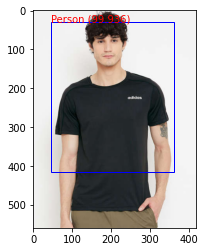

---draw_boxes = 0.1429119110107422  seconds ---


In [ ]:
# using yolo and cf model together
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6

# modifying get_boxes to detect only persons
# get all of the results above a threshold
def get_boxes(boxes, thresh):
  v_boxes, v_labels, v_scores = list(), list(), list()
  # enumerate all boxes
  for box in boxes:
    if box.classes[0] > thresh:
      v_boxes.append(box)
      v_labels.append('Person')
      v_scores.append(box.classes[0]*100)
		  # don't break, many labels may trigger for one box
  return v_boxes, v_labels, v_scores

# load and prepare an image
def load_image_pixels(filename, shape):
    image = cv2.imread(filename)
    width = image.shape[1]
    height = image.shape[0]
    # load the image with the required size
    image = cv2.resize(image,shape)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		# nb_class = len(boxes[0].classes)
		nb_class = 1
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0


def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

# model = load_model('model.h5')

# define the expected input shape for the model
input_w, input_h = 416, 416

# define our new photo
image_loc = 'Dress_Recognition/Test-Dataset/T-Shirt.67.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(image_loc, (input_w, input_h))

start_time = time.time()

# make prediction
yhat = model.predict(image)

print("--- model.predict = %s seconds ---" % (time.time() - start_time))

start_time = time.time()

# summarize the shape of the list of arrays
print([a.shape for a in yhat])
boxes = list()

# for i in range(len(yhat)):
# 	# decode the output of the network
# 	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
boxes += decode_netout(yhat[0][0], anchors[i], class_threshold, input_h, input_w)

print("--- decode_netout = %s seconds ---" % (time.time() - start_time))

start_time = time.time()
# correct the sizes of the bounding boxes for the shape of the image
# correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
correct_yolo_boxes(boxes, 416, 416, input_h, input_w)

print("--- correct_yolo_boxes = %s seconds ---" % (time.time() - start_time))
# suppress non-maximal boxes

start_time = time.time()
do_nms(boxes, 0.5)
v_boxes, v_labels, v_scores = get_boxes(boxes, class_threshold)

print("--- do_nms and get_boxes = %s seconds ---" % (time.time() - start_time))

# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

print("--- %s seconds ---" % (time.time() - start_time))

draw_boxes(image_loc, v_boxes, v_labels, v_scores)

print("---draw_boxes = %s  seconds ---" % (time.time() - start_time))


In [ ]:
person_test = cv2.imread(image_loc)
person_test = cv2.resize(person_test, (416,416))

29 45 416 363


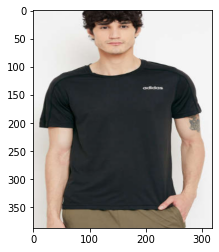

In [ ]:
v_boxes
y1, x1, y2, x2 = v_boxes[0].ymin, v_boxes[0].xmin, v_boxes[0].ymax, v_boxes[0].xmax
print(y1, x1, y2, x2)
plt.imshow((person_test[y1:y2,x1:x2,])[:,:,::-1])

In [ ]:
person_test[y1:y2,x1:x2,0]

array([[242, 242, 242, ..., 243, 243, 243],
       [242, 242, 242, ..., 243, 243, 243],
       [242, 242, 242, ..., 243, 243, 243],
       ...,
       [223, 223, 222, ..., 243, 243, 243],
       [224, 223, 222, ..., 243, 243, 243],
       [223, 223, 222, ..., 243, 243, 243]], dtype=uint8)

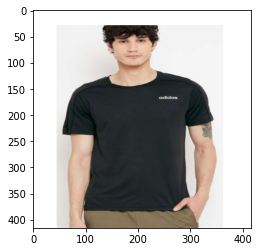

In [ ]:
color = (255,255,255)
padded_image = np.full((416,416,3), color, dtype=np.uint8)
# padded_image = np.zeros((416,416,3),dtype=np.uint8)
# padded_image.shape
padded_image[y1:y2,x1:x2] = person_test[y1:y2,x1:x2]
plt.imshow(padded_image[:,:,::-1])

In [ ]:
# padded_image = np.expand_dims(padded_image,0)
pad = []
pad.append(padded_image)
pad = np.array(pad)
prediction = cfmodel.predict_classes(pad)
categories[prediction]

array(['T-Shirt'], dtype='<U12')

In [ ]:
def detect_person(image_loc):
  image, image_w, image_h = load_image_pixels(image_loc, (416,416))
  yhat = model.predict(image)
  boxes = list()
  # for i in range(len(yhat)):
    # decode the output of the network
    # boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
  boxes += decode_netout(yhat[0][0], anchors[i], class_threshold, input_h, input_w)
  correct_yolo_boxes(boxes, 416, 416, input_h, input_w)
  do_nms(boxes, 0.5)
  v_boxes, v_labels, v_scores = get_boxes(boxes, class_threshold)
  return image, v_boxes, v_labels, v_scores

# start_time = time.time()

# print("--- %s seconds ---" % (time.time() - start_time))
# len(img_in_frame)


In [ ]:
def make_prediction(cropped_img, box):
  color = (255,255,255)
  padded_image = np.full((416,416,3), color, dtype=np.uint8)
  y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
  padded_image[y1:y2,x1:x2] = cropped_img[y1:y2,x1:x2]*255
  # plt.imshow(padded_image[:,:,::-1])
  # print(padded_image[y1:y2,x1:x2] )
  pad = []
  pad.append(padded_image)
  pad = np.array(pad)
  prediction = cfmodel.predict_classes(pad)
  categories[prediction]
  prediction = cfmodel.predict_classes(pad)
  return categories[prediction]

In [ ]:
import time
start_time = time.time()

img_in_frame,v_boxes, v_labels, v_scores = detect_person('Dress_Recognition/Test-Dataset/T-Shirt.81.jpg')
for i in range(len(img_in_frame)):
  print(make_prediction(img_in_frame[i], v_boxes[i]))

print("--- %s seconds ---" % (time.time() - start_time))

['T-Shirt']
--- 0.12205100059509277 seconds ---


In [ ]:
start_time = time.time()
img_in_frame,v_boxes, v_labels, v_scores = detect_person('Dress_Recognition/Test-Dataset/T-Shirt.80.jpg')
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.10506391525268555 seconds ---
